# Report Visualizations

### Imports and data loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from functools import partial

In [3]:
from preprocess.vizualisation import *
from eda.report import *

2025-07-07 21:19:47.067468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751890787.099059    3692 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751890787.108612    3692 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-07 21:19:47.149612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
os.getcwd()

'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/code'

In [5]:
path_to_root = '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'
interim_save_dir = path_to_root + 'data/assets/interim/'
final_save_dir = path_to_root + 'docs/assets/'

timestamp = "04242025"
motion_version = "versionB"
pose_version = "versionB"
preprocess_version = "v4"

metadata = pd.read_csv(path_to_root + f"data/preprocessed/landmarks_metadata_{preprocess_version}.csv")
metadata.head()


,filename,filename_accented,label,label_accented,accented,data_source,original_fps,original_frame_count,original_duration_sec,start_frame,end_frame,processed_frame_count,processed_duration_sec,preprocess_version,face_width,shoulders_width,face_midpoint_to_shoulders_height,left_hand_interpolated_none_frames,right_hand_interpolated_none_frames
0,ajudar_ne_1.mp4,ajudar_ne_1.mp4,ajudar,ajudar,False,ne,12.00000,44,3.666667,7,36,30,2.500000,v4,0.147576,0.333421,0.292776,7,6
1,ajudar_sb_2.mp4,ajudar_sb_2.mp4,ajudar,ajudar,False,sb,29.97003,79,2.635967,6,66,61,2.035367,v4,0.086359,0.206200,0.216821,0,0
2,ajudar_uf_3.mp4,ajudar_uf_3.mp4,ajudar,ajudar,False,uf,29.97003,115,3.837167,24,89,66,2.202200,v4,0.090604,0.205890,0.222293,0,0
3,ajudar_vl_4.mp4,ajudar_vl_4.mp4,ajudar,ajudar,False,vl,29.97003,141,4.704700,11,126,116,3.870533,v4,0.100236,0.210215,0.240169,25,9
4,ajudar_vl_5.mp4,ajudar_vl_5.mp4,ajudar,ajudar,False,vl,29.97000,108,3.603604,0,106,107,3.570237,v4,0.114839,0.243479,0.246769,13,12


In [6]:
def nested_dict_to_df(nested_dict, prefix=''):
    flat_dict = {}
    
    def flatten(d, parent_key=''):
        for key, value in d.items():
            new_key = f"{parent_key}_{key}" if parent_key else key
            
            if isinstance(value, dict):
                flatten(value, new_key)
            else:
                flat_dict[new_key] = value
    
    flatten(nested_dict)
    return pd.DataFrame([flat_dict])

In [7]:
analysis_info_list = []

for i, row in metadata.iterrows():
    fn = row["filename"]
    analysis_info_path = os.path.join(
        path_to_root, 
        "data", 
        "preprocessed", 
        "landmarks",
        preprocess_version,
        "individual_metadata",
        fn.replace("mp4", "json")
    )
    if os.path.exists(analysis_info_path):
        with open(analysis_info_path, "r") as f:
            analysis_info_dict = json.load(f)
    analysis_info_df = nested_dict_to_df(analysis_info_dict)
    analysis_info_list.append(analysis_info_df)

In [8]:
analysis_info = pd.concat(analysis_info_list, axis = 0).sort_values(by = "metadata_filename", ascending = True, key = lambda x: x.str.split("_").str[0] + x.str[-5]).reset_index(drop = True)

/tmp/ipykernel_3692/574225212.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  analysis_info = pd.concat(analysis_info_list, axis = 0).sort_values(by = "metadata_filename", ascending = True, key = lambda x: x.str.split("_").str[0] + x.str[-5]).reset_index(drop = True)


In [9]:
color_dict = {
    'ne': 'mediumorchid',       # i
    'sb': 'dodgerblue',     # s
    'uf': 'mediumseagreen',     # u
    'vl': 'darkorange',      # v
}
color_list = ['mediumorchid', 'dodgerblue', 'mediumseagreen', 'darkorange', 'darkorange', 'darkorange']
color_list_rgb = [colors.to_rgb(color) for color in color_list]
color_list_rgb_int = [(int(color[0]*255), int(color[1]*255), int(color[2]*255)) for color in color_list_rgb]
data_source_list = ['INES', 'SignBank', 'UFV', 'V-Librasil', 'V-Librasil', 'V-Librasil']

# Dataset

### Final Dataset

Example of each video for a word

In [10]:
word = 'banana'

In [11]:
word_metadata = metadata[metadata['label'] == word]
word_metadata

,filename,filename_accented,label,label_accented,accented,data_source,original_fps,original_frame_count,original_duration_sec,start_frame,end_frame,processed_frame_count,processed_duration_sec,preprocess_version,face_width,shoulders_width,face_midpoint_to_shoulders_height,left_hand_interpolated_none_frames,right_hand_interpolated_none_frames
24,banana_ne_1.mp4,banana_ne_1.mp4,banana,banana,False,ne,12.00000,51,4.250000,7,37,31,2.583333,v4,0.146253,0.335704,0.289209,9,10
25,banana_sb_2.mp4,banana_sb_2.mp4,banana,banana,False,sb,29.97003,71,2.369033,3,66,64,2.135467,v4,0.085460,0.204035,0.210855,0,1
26,banana_uf_3.mp4,banana_uf_3.mp4,banana,banana,False,uf,29.97003,246,8.208200,12,209,198,6.606600,v4,0.076263,0.174447,0.194980,3,0
27,banana_vl_4.mp4,banana_vl_4.mp4,banana,banana,False,vl,29.97000,168,5.605606,1,143,143,4.771438,v4,0.103197,0.236290,0.247538,1,16
28,banana_vl_5.mp4,banana_vl_5.mp4,banana,banana,False,vl,59.94006,378,6.306300,20,289,270,4.504500,v4,0.132493,0.285565,0.289806,0,1
29,banana_vl_6.mp4,banana_vl_6.mp4,banana,banana,False,vl,59.94006,355,5.922583,2,349,348,5.805800,v4,0.125241,0.284814,0.286766,12,16


In [12]:
video_paths = [os.path.join(path_to_root, 'data', 'interim', 'RawCleanVideos', fn) for fn in word_metadata['filename']]

In [14]:
combine_function = partial(all_signs_for_word, word=word)

In [15]:
apply_to_videos(combine_function=combine_function, video_paths=video_paths, save_path=interim_save_dir+f"all_signs_for_{word}.mp4")

Video 1: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_ne_1.mp4
  - FPS: 12.00
  - Frames: 51
  - Size: 240x176
  - Duration: 4.25s
Video 2: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_sb_2.mp4
  - FPS: 29.97
  - Frames: 71
  - Size: 1920x1080
  - Duration: 2.37s
Video 3: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_uf_3.mp4
  - FPS: 29.97
  - Frames: 246
  - Size: 1920x1080
  - Duration: 8.21s
Video 4: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_vl_4.mp4
  - FPS: 29.97
  - Frames: 168
  - Size: 1920x1080
  - Duration: 5.61s
Video 5: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/interim/RawCleanVideos/banana_vl_5.mp4
  - FPS: 59.94
  - Frames: 378
  - Size: 1280x720
  - Duration: 6.31s
Video 6: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguag

[ERROR:0@99.871] global cap_ffmpeg_impl.hpp:3203 open Could not find encoder for codec_id=27, error: Encoder not found
[ERROR:0@99.872] global cap_ffmpeg_impl.hpp:3281 open VIDEOIO/FFMPEG: Failed to initialize VideoWriter


Progress: 6.1% (30 frames processed)
Progress: 12.2% (60 frames processed)
Progress: 18.3% (90 frames processed)
Progress: 24.4% (120 frames processed)
Progress: 30.5% (150 frames processed)
Progress: 36.6% (180 frames processed)
Progress: 42.7% (210 frames processed)
Progress: 48.8% (240 frames processed)
Progress: 54.9% (270 frames processed)
Progress: 61.0% (300 frames processed)
Progress: 67.1% (330 frames processed)
Progress: 73.2% (360 frames processed)
Progress: 79.3% (390 frames processed)
Progress: 85.4% (420 frames processed)
Progress: 91.5% (450 frames processed)
Progress: 97.6% (480 frames processed)

Video saved successfully: /home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/assets/interim/all_signs_for_banana.mp4
Total frames processed: 492
Final duration: 8.21s
File size: 3.9 MB


'/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/data/assets/interim/all_signs_for_banana.mp4'

In [ ]:
# video_to_gif(video_path="comb_video.mp4", output_path="comb_video.gif", loop=0, quality=100, fps=15, final_frame_duration= 500)

GIF created successfully: comb_video.gif
  - Frames: 164
  - Duration: 11.26 seconds
  - Size: 1920x292
  - File size: 8803.2 KB


'comb_video.gif'

### Dimensions & FPS

#### Dimensions

In [16]:
video_metadata = pd.read_csv(path_to_root + f"data/raw/combined/target_dataset_video_metadata.csv")
video_metadata.head()

,filename,label,data_source,sign_id,signer_number,frame_count,fps,duration_sec,width,height,needs_flip,cleaned
0,ajudar_ne_1.mp4,ajudar,ne,2,1,44,12.00000,3.666667,240,176,False,True
1,ajudar_sb_2.mp4,ajudar,sb,1,1,79,29.97003,2.635967,1280,720,False,True
2,ajudar_uf_3.mp4,ajudar,uf,0,1,115,29.97003,3.837167,480,270,False,True
3,ajudar_vl_4.mp4,ajudar,vl,0,1,141,29.97003,4.704700,1920,1080,False,True
4,ajudar_vl_5.mp4,ajudar,vl,0,2,108,29.97000,3.603604,1920,1080,False,True


In [18]:
video_metadata.data_source.value_counts()

data_source
vl    75
ne    25
sb    25
uf    25
Name: count, dtype: int64

In [19]:
video_metadata['dimension_str'] = video_metadata['width'].astype(str) + 'x' + video_metadata['height'].astype(str)

(array([0, 1, 2, 3]),
 [Text(0, 0, '240x176'),
  Text(1, 0, '480x270'),
  Text(2, 0, '1280x720'),
  Text(3, 0, '1920x1080')])

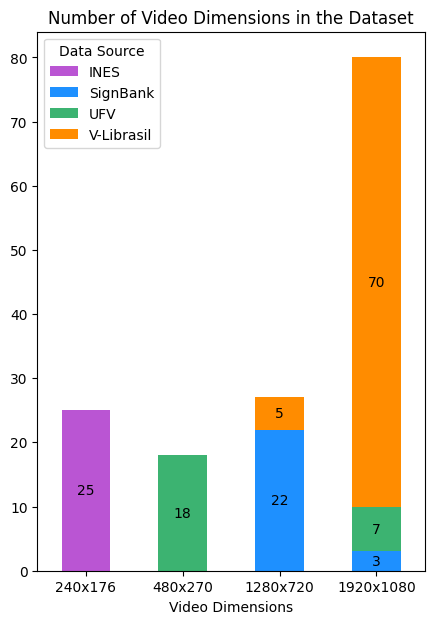

In [56]:
dimension_counts = video_metadata.sort_values('width').groupby('dimension_str').data_source.value_counts().unstack()
# rearrange rows, so the order goes from indexes 1,2,3,4 to 3,4,1,2
dimension_counts = dimension_counts.reindex(index=['240x176', '480x270', '1280x720', '1920x1080'])
# dimension_counts = dimension_counts[['240x176', '480x270', '1280x720', '1920x1080']]
ax = dimension_counts.plot(kind='bar', stacked=True, color=color_list_rgb, figsize=(5, 7))

# Add value labels on top of each bar segment
y_offset = np.zeros(len(dimension_counts.index))
for i, col in enumerate(dimension_counts.columns):
    values = dimension_counts[col]
    for j, v in enumerate(values):
        if not np.isnan(v):  # Only add label if value is not NaN
            ax.text(j, y_offset[j] + v/2, int(v), 
                   ha='center', va='center', color='black')
        if not np.isnan(v):
            y_offset[j] += v

# add a legend
plt.legend(title='Data Source', labels=data_source_list)

# add a title
plt.title('Number of Video Dimensions in the Dataset')

# add a x label
plt.xlabel('Video Dimensions')

# clearer xticks
plt.xticks(rotation=0)


In [81]:
word = 'animal'
word_metadata = video_metadata[video_metadata['label'] == word].reset_index(drop=True)
video_paths = [os.path.join(path_to_root, 'data', 'interim', 'RawCleanVideos', fn) for fn in word_metadata['filename'][:4]]
video_frames = [get_frame(10, video_path) for video_path in video_paths]

In [82]:
word_metadata

,filename,label,data_source,sign_id,signer_number,frame_count,fps,duration_sec,width,height,needs_flip,cleaned,dimension_str
0,animal_ne_1.mp4,animal,ne,0,1,71,12.000000,5.916667,240,176,False,True,240x176
1,animal_sb_2.mp4,animal,sb,1,1,74,29.970030,2.469133,1280,720,False,True,1280x720
2,animal_uf_3.mp4,animal,uf,0,1,127,29.970030,4.237567,480,270,False,True,480x270
3,animal_vl_4.mp4,animal,vl,0,1,116,23.976024,4.838167,1920,1080,False,True,1920x1080
4,animal_vl_5.mp4,animal,vl,0,2,145,29.970030,4.838167,1920,1080,False,True,1920x1080
5,animal_vl_6.mp4,animal,vl,0,3,181,29.970030,6.039367,1920,1080,False,True,1920x1080


In [163]:
target_width = 1920
target_height = 1080
black_border = 2
color_border = 20
dimension_frames = []
for i, row in word_metadata[:4].iterrows():
    fn = row['filename']
    video_path = os.path.join(path_to_root, 'data', 'interim', 'RawCleanVideos', fn)
    video_frame = get_frame(row['frame_count']//2-3, video_path)
    color = color_list_rgb_int[i]
    height, width = video_frame.shape[:2]
    if target_width > width:
        video_frame = cv2.copyMakeBorder(video_frame, top=black_border, bottom=black_border, left=black_border, right=black_border, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
        width_padding = (target_width - width) // 2 - black_border
        height_padding = (target_height - height) // 2 - black_border
        video_frame = cv2.copyMakeBorder(video_frame, top=height_padding, bottom=height_padding, left=width_padding, right=width_padding, borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))
    video_frame = cv2.copyMakeBorder(video_frame, top=color_border, bottom=color_border, left=color_border, right=color_border, borderType=cv2.BORDER_CONSTANT, value=color)
    
    dimension_frames.append(video_frame)

font_size = 6
font_thickness = 5
font = cv2.FONT_HERSHEY_TRIPLEX

padded_annotated_frames = []
for i, frame in enumerate(dimension_frames):
    data_source = data_source_list[i]
    anno = f'{word_metadata.loc[i, "width"]}x{word_metadata.loc[i, "height"]}'
    bordered_frame = cv2.copyMakeBorder(frame, 0, 600, 0, 0, cv2.BORDER_CONSTANT, value=(255,255,255))

    textsize = cv2.getTextSize(anno, font, font_size, font_thickness)[0]
    text_x = (target_width - textsize[0]) // 2
    annotated_frame = cv2.putText(bordered_frame, anno, (text_x, 1350), font, font_size, (0, 0, 0), font_thickness)

    textsize = cv2.getTextSize(data_source, font, font_size, font_thickness)[0]
    text_x = (target_width - textsize[0]) // 2
    annotated_frame = cv2.putText(annotated_frame, f"({data_source})", (text_x, 1350 + int(textsize[1]*1.5)), font, 5, (0, 0, 0), font_thickness)
    
    padded_annotated_frames.append(annotated_frame)

gap = np.full((target_height + 390 + 250, 250, 3), 255, dtype=np.uint8)

final_frames = [padded_annotated_frames[0], gap, padded_annotated_frames[2], gap, padded_annotated_frames[1], gap, padded_annotated_frames[3]]
new_frame = np.concatenate(final_frames, axis=1)
new_frame = cv2.copyMakeBorder(new_frame, 600, 0, 300, 300, cv2.BORDER_CONSTANT, value=(255, 255, 255))
font_size = 10
font_thickness = 15
textsize = cv2.getTextSize(word, font, font_size, font_thickness)[0]
text_x = (new_frame.shape[1] - textsize[0]) // 2
new_frame = cv2.putText(new_frame, word, (text_x, 400), font, font_size, (0, 0, 0), font_thickness)


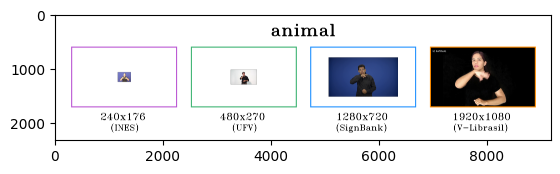

In [164]:
plt.imshow(new_frame)

#### FPS

In [98]:
video_metadata['round_fps'] = video_metadata['fps'].round(0).astype(int)
video_metadata.groupby('round_fps').data_source.value_counts()

round_fps  data_source
12         ne             25
24         vl              1
30         vl             47
           sb             25
           uf             25
60         vl             27
Name: count, dtype: int64

Text(0.5, 0, 'FPS')

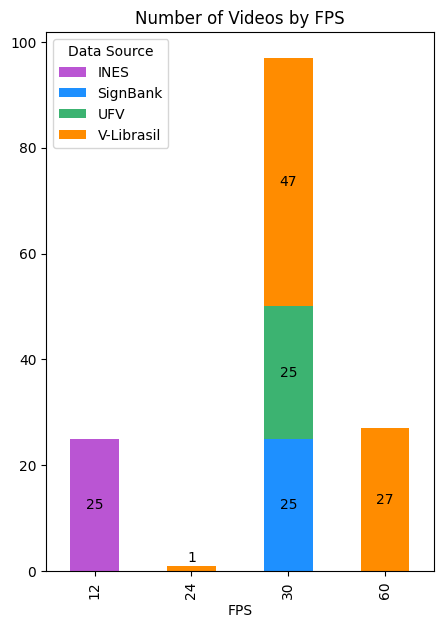

In [111]:
fps_counts = video_metadata.sort_values('round_fps').groupby('round_fps').data_source.value_counts().unstack()
ax = fps_counts.plot(kind='bar', stacked=True, color=color_list_rgb, figsize=(5, 7))

# Add value labels on top of each bar segment
y_offset = np.zeros(len(fps_counts.index))
for i, col in enumerate(fps_counts.columns):
    values = fps_counts[col]
    for j, v in enumerate(values):
        if not np.isnan(v):  # Only add label if value is not NaN
            if v == 1:
                ax.text(j, y_offset[j]+ 2.5, int(v), 
                       ha='center', va='center', color='black')
            else:
                ax.text(j, y_offset[j] + v/2, int(v), 
                       ha='center', va='center', color='black')
        if not np.isnan(v):
            y_offset[j] += v

# add a legend
plt.legend(title='Data Source', labels=data_source_list)

# add a title
plt.title('Number of Videos by FPS')

# add a x label
plt.xlabel('FPS')

# clearer xticks
# plt.xticks(rotation=0)


### Durations

# Preprocessing

### Pose - MediaPipe

### Motion Detection Measurement Methods

### Motion Start & End Frame Methods

### Scaling & Alignment

### Interpolation

### Summary

# Modelling

### Train / Test Split

### Frame Sampling

### Cross Validation Split (StratifiedGroupKFold)

### Data Augmentation